In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm

In [1]:
# Seth DATADIR
DATADIR = "/Users/sethbilliau/Desktop/stat143/repo/project1/data/"

In [ ]:
# Sarah DATADIR TODO
DATADIR = "/Users/sethbilliau/Desktop/stat143/code/data/"

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 25 08:54:32 2020

@author: laurieshaw
"""




# Seth DATADIR
DATADIR = "/Users/sethbilliau/Desktop/stat143/code/data/"

def load_nfl_data(season=2017):
    NFL = pd.read_csv(DATADIR+'NFL_Scores.csv')

    # select the 2017/18 season
    NFL_season = NFL[NFL.schedule_season==season]
    # remove play-off games
    NFL_season = NFL_season.iloc[:-11]
    return NFL_season

def get_X(teams,NFL_season):
    # calculate number of teams
    nteams = teams.size
    # calculate number of games
    ngames = NFL_season.shape[0]
    # assign each game a unique id
    game_id = np.arange(ngames)
    # initalize X matrix
    X = np.zeros((ngames,nteams))
    # populate home teams
    home_team_idx = np.searchsorted(teams,NFL_season.team_home)
    X[game_id,home_team_idx] = 1
    # populate away teams
    away_team_idx = np.searchsorted(teams,NFL_season.team_away)
    X[game_id,away_team_idx] = -1    
    return X

def get_W(nteams):
    # set up an nteams x nteams identify matrix
    W = np.eye(nteams)
    # set all elements in the last row = -1
    W[-1,:] = -1
    # remove the last column
    W = W[:,:-1]
    return W

def make_team_strength_plot(season,team_params):
    teamnames = [t[0] for t in team_params]
    theta_ = [t[1] for t in team_params]
    # plot outcomes
    fig, ax = plt.subplots(figsize=(6,8))
    ax.barh(teamnames,theta_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('Logistic model team strength estimates, NFL %d-%d' % (season,season+1),y=0.92)
    ax.set_xlabel('Team strength')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)


In [3]:
season = 2015 # model fails to converge for 2017 season: can you figure out why?
NFL_season = load_nfl_data(season=season)

# find all the team names
teams = np.unique( NFL_season[['team_home','team_away']] )
# calculate number of teams
nteams = teams.size
# calculate number of games
ngames = NFL_season.shape[0]
# calculate design matrix
X = get_X(teams,NFL_season)
# get observed score differentials
y = NFL_season.score_home - NFL_season.score_away
# construct linear constraint matrix
W = get_W(nteams)
# extend W to account for home advantage parameter
Wh = block_diag(W,[1])

Xh = np.c_[X,np.ones(ngames)]
Xhs = np.matmul(Xh,Wh)


outcome = np.zeros_like(y)
outcome[y>0] = 1.0
outcome[y==0] = 0.5

In [4]:

logit_mod = sm.Logit(outcome, Xhs)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.532822
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  256
Model:                          Logit   Df Residuals:                      224
Method:                           MLE   Df Model:                           31
Date:                Sat, 27 Feb 2021   Pseudo R-squ.:                  0.2279
Time:                        11:07:06   Log-Likelihood:                -136.40
converged:                       True   LL-Null:                       -176.66
Covariance Type:            nonrobust   LLR p-value:                 2.794e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8173      0.687      2.646      0.008       0.471       3.163
x2            -0.3549      0.

Carolina Panthers,2.466,1.043
Arizona Cardinals,1.817,0.687
Denver Broncos,1.465,0.626
Cincinnati Bengals,1.385,0.648
Minnesota Vikings,1.237,0.607
Kansas City Chiefs,1.140,0.613
Green Bay Packers,1.114,0.606
Seattle Seahawks,1.053,0.614
New England Patriots,0.843,0.632
Pittsburgh Steelers,0.829,0.600
Detroit Lions,0.170,0.570
St. Louis Rams,0.073,0.587
New York Jets,0.036,0.577
Houston Texans,-0.029,0.594
Oakland Raiders,-0.065,0.591
Chicago Bears,-0.092,0.577
Washington Redskins,-0.103,0.568
Buffalo Bills,-0.275,0.574
Indianapolis Colts,-0.316,0.588
Atlanta Falcons,-0.355,0.572
San Francisco 49ers,-0.494,0.601
Philadelphia Eagles,-0.524,0.581
New Orleans Saints,-0.562,0.594
New York Giants,-0.821,0.575
Baltimore Ravens,-0.844,0.631
Tampa Bay Buccaneers,-0.914,0.586
Miami Dolphins,-1.022,0.565
San Diego Chargers,-1.052,0.650
Dallas Cowboys,-1.303,0.627
Jacksonville Jaguars,-1.361,0.601
Cleveland Browns,-1.514,0.719
Tennessee Titans,-1.983,0.679
Beta,0.198, 0.148


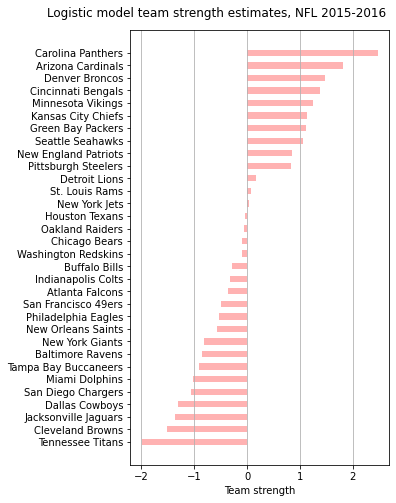

In [5]:
gamma = logit_res.params
theta_n1 = gamma[:-1]
#  home advantage parameter
beta = gamma[-1]
# calculate the nth team strength
theta_n = np.append( theta_n1,-theta_n1.sum() )

# these lines show how to calculate covariance of theta estimates (see, for example, https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients)
yp = logit_res.predict(Xhs)
V = np.diag(yp*(1-yp))
theta_cov = Wh @ np.linalg.inv( Xhs.T @ V @ Xhs ) @ Wh.T  # square root of diagonal element should match std err in printout
theta_sigma = np.sqrt( theta_cov.diagonal() )

# now list & plot soltuions
team_params = []
for team,theta,sigma in zip(teams,theta_n,theta_sigma):
    team_params.append((team,theta.round(3),sigma.round(3)))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
for tp in team_params[::-1]:
    print("%s,%1.3f,%1.3f" % tuple(tp))
print("Beta,%1.3f, %1.3f" % (beta,theta_sigma[-1]))


# MAKE_PLOT
make_team_strength_plot(season,team_params)

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 26 16:00:35 2020

@author: laurieshaw
"""


def run_sims(team_param_dict,nsims=10000,draw_strengths=True):    
    # we'll simulated the 2015/16 season using team strengths measured from the 2014/15 season
    season = 2015 # i.e. 2015/16 season

    # load data
    EPLseason = pd.read_csv(DATADIR+'EPL_%d%d.csv' % (season-2000,season-2000+1))

    # get fixture schedule    
    fixtures = EPLseason[['HomeTeam','AwayTeam']]
    teams = np.unique( fixtures[['HomeTeam','AwayTeam']] )
    
    # calculate the average of team strength of teams that were relegated in the 2014/15 season
    relegated_teams_theta = (team_param_dict['Hull']+team_param_dict['Burnley']+team_param_dict['QPR'])/3.
    # assign this average strength to the newly promoted teams (beacuse they werent in the league in 2014/15)
    promoted_teams = ['Bournemouth','Watford','Norwich']
    for promoted_team in promoted_teams:
        team_param_dict[promoted_team] = relegated_teams_theta
    
    # store the league tables for each simulation in a list    
    tables = []
    # now run the simulations
    for i in tqdm(np.arange(nsims)):
        if draw_strengths:
            # treat the team strength of each team as a random varaible, drawing from a distribution determined by their expected value and sample error
            sim_param_dict = draw_from_strength_params(teams,team_param_dict)
        else:
            # don't draw team strenghts, just keep them fixed at their expected value
            sim_param_dict = team_param_dict
        # simulate the season once
        completed_fixtures = sim_season(fixtures,sim_param_dict)
        # append the league table for simulated season to the list
        tables.append( generate_table(completed_fixtures) )
        
    team_summary = analyse_sim_results(tables, teams)
    return tables,team_summary


def draw_from_strength_params(teams,team_param_dict,sigma_teams=0.1,sigma_beta=0.3):
    '''
    Draw a new set of team strength, home advantage and intercept parameters from the standard errors on the theta values
    '''
    sim_param_dict = team_param_dict.copy()
    for team in teams:
        sim_param_dict[team] = stats.norm.rvs(0,sigma_teams,1)[0] + team_param_dict[team]
    
    sim_param_dict['intercept'] = stats.norm.rvs(0,sigma_beta,1)[0] + team_param_dict['intercept']
    sim_param_dict['beta'] = stats.norm.rvs(0,sigma_beta,1)[0] + team_param_dict['beta']
    return sim_param_dict

def sim_match(home,away,team_param_dict):
    # calculate lambda (goal scoring rate parameters from team strenghts & home advantage)
    lambda_home = np.exp( team_param_dict[home] - team_param_dict[away] + team_param_dict['intercept'] + team_param_dict['beta'] )
    lambda_away = np.exp( team_param_dict[away] - team_param_dict[home] + team_param_dict['intercept'] - team_param_dict['beta'] )
    # draw a poisson random variable
    hg = stats.poisson.rvs(lambda_home)
    ag = stats.poisson.rvs(lambda_away)
    return hg,ag

def sim_season(fixtures,team_param_dict):
    '''
    simulate a single season using the fixtures given in the 'fixtures' dataframe
    '''
    # make a copy of the fixture list. we'll populate this with the results
    completed_fixtures = fixtures.copy()
    nmatches = fixtures.shape[0]
    HomeGoals = np.zeros(nmatches,dtype=int)
    AwayGoals = np.zeros(nmatches,dtype=int)
    # go through fixture schedule and simulated each match
    for i,row in completed_fixtures.iterrows():
        HomeGoals[i],AwayGoals[i] =sim_match(row['HomeTeam'],row['AwayTeam'],team_param_dict)
    # fill in scores in fixture schedule
    completed_fixtures['HomeGoals'] = HomeGoals
    completed_fixtures['AwayGoals'] = AwayGoals
    return completed_fixtures
    
def generate_table(results):
    ''' 
    produce a league table from a simulation of a single team
    '''
    teams = np.unique( results[['HomeTeam','AwayTeam']] )
    table = []
    # loop through each team
    for team in teams:
        # get all the team's home & away games
        homegames = results[results['HomeTeam']==team]
        awaygames = results[results['AwayTeam']==team]
        # calculate total number of goals scored
        GoalsFor = np.sum(homegames.HomeGoals) + np.sum(awaygames.AwayGoals)
        # calculate total number of goals conceded
        GoalsAgainst = np.sum(awaygames.HomeGoals) + np.sum(homegames.AwayGoals)
        # calculate total number of points won in home games
        HomePoints = 3*np.sum(homegames.HomeGoals>homegames.AwayGoals) + 1*np.sum(homegames.AwayGoals==homegames.HomeGoals)
        # calculate total number of points won in away games
        AwayPoints = 3*np.sum(awaygames.AwayGoals>awaygames.HomeGoals) + 1*np.sum(awaygames.AwayGoals==awaygames.HomeGoals)
        # add to get total points
        TotalPoints = HomePoints + AwayPoints
        # append results to the table list
        table.append((team,TotalPoints,GoalsFor-GoalsAgainst,GoalsFor,GoalsAgainst))
    # sort the table by points, then goal difference, then goals for
    table = sorted(table, key = lambda x: (x[1],x[2],x[3]), reverse=True)
    return table
    
def analyse_sim_results(tables,teams,printout=True):
    '''
    analyse the simulation results over all simulations
    '''
    team_summary = []
    nsims = len(tables)
    for team in teams:
        # the final of positions of the team in each sim
        positions = np.array( [[t[0] for t in table].index(team)+1 for table in tables] )
        # the final of points of the team in each sim
        points = np.array([table[position-1][1] for table,position in zip(tables,positions)])
        # proportion of sims in which team finished first in the league table
        title = np.sum(positions==1)/nsims*100
        # proportion of sims in which team finished in the top 4 
        top4 = np.sum(positions<=4)/nsims*100
        # proportion of sims in which team finished in the bottom 3 (i.e. were relegated)
        rel = np.sum(positions>=17)/nsims*100
        # average position
        position_mean = np.mean(positions)
        # 2.5th percentile of finishes (by position)
        position_low = np.percentile(positions,2.5)
        # 97.5th percentile of finishes
        position_high = np.percentile(positions,97.5)
        # average points
        points_mean = np.mean(points)
        # 2.5th and 97.5th percentiles of points
        points_low = np.percentile(points,2.5)
        points_high = np.percentile(points,97.5)
        # add to summary table
        team_summary.append( [position_mean,team,points_mean,points_low,points_high,position_low,position_high,title,top4,rel] )
    # sort summary table by mean position
    team_summary = sorted( team_summary, key = lambda x: x[0], reverse=False)
    if printout:
        print("\n******* SUMMARY OF SIMULATION RESULTS **********\n")
        print("Position, Team,Points-Mean,Points-Low,Points-High,Position-Low,Position-High,Title,Top4,Relegation")
        for i,summary in enumerate(team_summary):
            print("%d,%s,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f" % tuple([i+1]+summary[1:]))
    return team_summary




### NHL 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 30 14:16:29 2020

@author: laurieshaw
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

def get_X(teams,NHL_season):
    # calculate number of teams
    nteams = teams.size
    # calculate number of games
    ngames = NHL_season.shape[0]
    # assign each game a unique id
    game_id = np.arange(ngames)
    # do attack first
    # initalize X matrix
    Xh = np.zeros((ngames,nteams))
    # populate home teams
    home_team_idx = np.searchsorted(teams,NHL_season.Home)
    Xh[game_id,home_team_idx] = 1
    # populate away teams
    away_team_idx = np.searchsorted(teams,NHL_season.Visitor)
    Xh[game_id,away_team_idx] = -1
    
    # stack -Xh below Xg, as discussed in class
    X = np.vstack((Xh,-Xh))
    return X

def get_W(nteams):
    # set up an nteams x nteams identify matrix
    W = np.eye(nteams)
    # set all elements in the last row = -1
    W[-1,:] = -1
    # remove the last column
    W = W[:,:-1]
    return W

def make_team_strength_plot(season,team_params,ix=1):
    fig, ax = plt.subplots(figsize=(6,8))
    teamnames = [t[0] for t in team_params]
    lambda_ = [t[ix] for t in team_params]
    ax.barh(teamnames,lambda_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('         Team strength estimates, NHL %d-%d' % (season,season+1),y=0.95)
    if ix==1:
        ax.set_xlabel('Expected goals scored\n(vs average opponent at neutral venue)')
    elif ix==2:
        ax.set_xlabel('Team strength estimate')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)
    #ax.set_xticklabels(teams)





In [7]:
# first load the NHL scoreline data
DATADIR = "/Users/sethbilliau/Desktop/stat143/code/data/"
NHL = pd.read_csv(DATADIR+'scores_2009_2019.csv')

# get season results for 2017/18
season = 2017
NHL_season = NHL[NHL.Season==season]

# we want to model the scorlines in regular time (not overtime), so correct scores to reflect this

# first find all games that ended in overtime or a shootout
OT = (NHL_season['OT']=='OT') | (NHL_season['OT']=='SO') 
# home and away goals
homegoals = NHL_season.Home_Goals.values
awaygoals = NHL_season.Visitor_Goals.values
# game ended in OT and home team won
homewinOT = OT & (homegoals>awaygoals)
# game ended in OT and away team won
awaywinOT = OT & (homegoals<awaygoals)
# reduce the number of home goals by 1 when home team won in OT
homegoals[homewinOT]  = homegoals[homewinOT]-1
# reduce the number of home goals by 1 when away team won in OT
awaygoals[awaywinOT]  = awaygoals[awaywinOT]-1

teams = np.unique( NHL_season[['Visitor','Home']] )
# calculate number of teams
nteams = teams.size
# calculate number of games
ngames = NHL_season.shape[0]




In [10]:
# calculate design matrix
X = get_X(teams,NHL_season)
# construct linear constraint matrix
W = get_W(nteams)

Xs = np.matmul(X,W)
# add an extra column for the home advantage parameter 
Xs = np.c_[Xs,np.concatenate((np.ones(ngames),-1*np.ones(ngames)))]

print(Xs)

[[ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]
 ...
 [ 1.  1.  1. ...  1.  1. -1.]
 [ 0.  0.  0. ...  0. -1. -1.]
 [ 0.  0. -1. ...  0.  0. -1.]]


In [ ]:
# in STATSMODELS: USE THIS ONE
k = np.concatenate((homegoals,awaygoals))
Xs = sm.add_constant(Xs) # add intercept (because we're modelling goals scored, not score differentials now)
# set up poisson model
poisson_model = sm.Poisson(k, Xs)
# fit poisson model
poisson_res = poisson_model.fit()
# print results
print(poisson_res.summary())


Winnipeg Jets,3.231,0.131
Nashville Predators,3.209,0.124
Boston Bruins,3.177,0.114
Tampa Bay Lightning,3.138,0.102
Vegas Golden Knights,3.075,0.082
Toronto Maple Leafs,3.056,0.076
Los Angeles Kings,3.043,0.071
Minnesota Wild,3.009,0.060
Colorado Avalanche,2.982,0.051
Anaheim Ducks,2.982,0.051
San Jose Sharks,2.977,0.049
Washington Capitals,2.912,0.027
Dallas Stars,2.911,0.027
Pittsburgh Penguins,2.900,0.023
Philadelphia Flyers,2.882,0.017
St. Louis Blues,2.853,0.007
Columbus Blue Jackets,2.841,0.003
Florida Panthers,2.840,0.002
New Jersey Devils,2.830,-0.001
Chicago Blackhawks,2.725,-0.039
Carolina Hurricanes,2.689,-0.052
Calgary Flames,2.677,-0.057
Edmonton Oilers,2.645,-0.069
New York Islanders,2.640,-0.071
Detroit Red Wings,2.633,-0.073
Vancouver Canucks,2.616,-0.080
New York Rangers,2.608,-0.083
Arizona Coyotes,2.596,-0.088
Montreal Canadiens,2.559,-0.102
Ottawa Senators,2.448,-0.146
Buffalo Sabres,2.418,-0.159
Beta,0.049


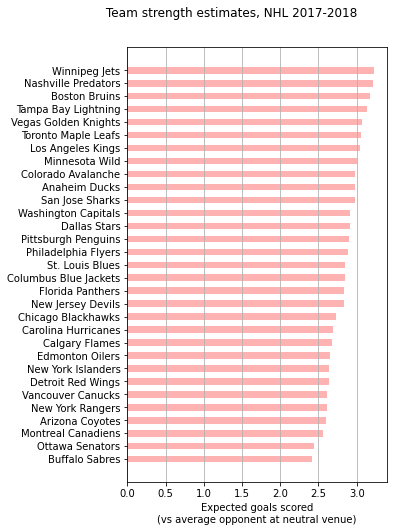

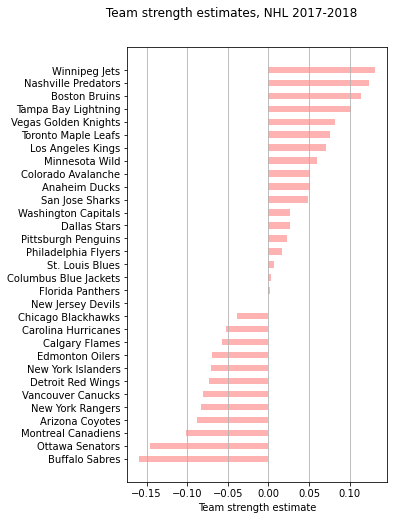

In [5]:
# get parameters
intercept = poisson_res.params[0] # because we're modelling goals scored, not socre differentials now
beta = poisson_res.params[-1] # home advantage parameter
theta_att = poisson_res.params[1:nteams]
# get theta for final team (based on linear contraint)
theta_att = np.append(theta_att,-np.sum(theta_att))
# turn the thetas into expected goals per game (vs average opponent)
lambda_att = np.exp(intercept + theta_att)

# print out results
team_params = []
for t,a,l in zip(teams,lambda_att,theta_att):
    team_params.append((t,a.round(3),l.round(3)))
    
team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
for params in team_params[::-1]:
    print("%s,%1.3f,%1.3f" % tuple(params))
print("Beta,%1.3f" % (beta))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
make_team_strength_plot(season,team_params,ix=1)
make_team_strength_plot(season,team_params,ix=2)

In [6]:
lambda_att

array([2.98190876, 2.59575954, 3.17654825, 2.418016  , 2.67709408,
       2.68895538, 2.72539859, 2.98233995, 2.84143829, 2.91093156,
       2.63319203, 2.64483797, 2.83978473, 3.04266483, 3.00856684,
       2.55923445, 3.20861562, 2.82986192, 2.64002463, 2.60790828,
       2.44754969, 2.88234441, 2.90002969, 2.97666848, 2.85273446,
       3.13804362, 3.05618817, 2.61598942, 3.07508708, 2.91194604,
       3.23068973])

# Lecture 6 

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 30 14:16:29 2020

@author: laurieshaw
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm

DATADIR = "/Users/sethbilliau/Desktop/stat143/code/data/"

def get_X(teams,EPLseason):
    nteams = teams.size
    ngames = EPLseason.shape[0]
    
    game_id = np.arange(ngames)
    # do attack first
    
    Xh = np.zeros((ngames,nteams))
    home_team_idx = np.searchsorted(teams,EPLseason.HomeTeam)
    Xh[game_id,home_team_idx] = 1
    away_team_idx = np.searchsorted(teams,EPLseason.AwayTeam)
    Xh[game_id,away_team_idx] = -1
    
    X = np.vstack((Xh,-Xh))
    return X

def get_W(nteams):
    W = np.eye(nteams)
    W[-1,:] = -1
    W = W[:,:-1]
    return W

def make_prediction(homename,awayname,thetas,intercept,beta,teams):
    lambda_home = np.exp( thetas[teams==homename] - thetas[teams==awayname] + intercept + beta )
    lambda_away = np.exp( thetas[teams==awayname] - thetas[teams==homename] + intercept - beta )
    score_difs = np.arange(-10,11,1)
    pmf = stats.skellam.pmf(score_difs,lambda_home,lambda_away)
    HW = np.sum(pmf[score_difs>0])
    AW = np.sum(pmf[score_difs<0])
    D = np.sum(pmf[score_difs==0])
    print('Home lambda: %1.2f, Away lambda: %1.2f' % (lambda_home,lambda_away))
    print('Home Win %d%% Away win %d%% Tie %d%%' % (HW*100,AW*100,D*100))

def make_team_strength_plot(season,team_params):
    teamnames = [t[0] for t in team_params]
    lambda_ = [t[1] for t in team_params]
    theta_ = [t[2] for t in team_params]
    fig, ax = plt.subplots(figsize=(6,8))
    ax.barh(teamnames,lambda_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('         Team scoring rates, EPL %d-%d' % (season,season+1),y=0.92)
    ax.set_xlabel('Expected goals scored\n(vs average opponent at neutral venue)')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)
    
    fig, ax = plt.subplots(figsize=(6,8))
    ax.barh(teamnames,theta_,facecolor='red',alpha=0.3,height=0.5)
    fig.suptitle('         Team strength estimates, EPL %d-%d' % (season,season+1),y=0.92)
    ax.set_xlabel('Team strength')
    ax.xaxis.grid(True)
    fig.subplots_adjust(left=0.3)
    #ax.set_xticklabels(teams)






In [9]:
# first load the EPL scoreline data
season = 2014 # i.e., 2014/15
EPLseason = pd.read_csv(DATADIR+'EPL_%d%d.csv' % (season-2000,season+1-2000))

homegoals = EPLseason.HomeGoals.values
awaygoals = EPLseason.AwayGoals.values

teams = np.unique( EPLseason[['HomeTeam','AwayTeam']] )
# calculate number of teams
nteams = teams.size
# calculate number of games
ngames = EPLseason.shape[0]
# calculate design matrix
X = get_X(teams,EPLseason)
# construct linear constraint matrix
W = get_W(nteams)

Xs = np.matmul(X,W)
Xs = np.c_[Xs,np.concatenate((np.ones(ngames),-1*np.ones(ngames)))]

k = np.concatenate((homegoals,awaygoals))
Xs = sm.add_constant(Xs) # add home advantage parameter (as intercept)
poisson_model = sm.Poisson(k, Xs)
poisson_res = poisson_model.fit()
print(poisson_res.summary())



Optimization terminated successfully.
         Current function value: 1.394451
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  760
Model:                        Poisson   Df Residuals:                      739
Method:                           MLE   Df Model:                           20
Date:                Sat, 27 Feb 2021   Pseudo R-squ.:                 0.05309
Time:                        11:12:36   Log-Likelihood:                -1059.8
converged:                       True   LL-Null:                       -1119.2
Covariance Type:            nonrobust   LLR p-value:                 4.699e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1877      0.034      5.527      0.000       0.121       0.254
x1             0.3444      0.

In [10]:
# get parameters
intercept = poisson_res.params[0]
beta = poisson_res.params[-1]
thetas = poisson_res.params[1:nteams]
thetas = np.append(thetas,-np.sum(thetas))
lambdas = np.exp(intercept + thetas)
theta_cov = poisson_res.normalized_cov_params[1:-1,1:-1]
sigma_theta = np.sqrt(np.diagonal(theta_cov))
sigma_theta = np.append(sigma_theta,theta_cov.sum())


# param dictionary. For use in running simulations
team_param_dict = {t:th for t,th in zip(teams,np.round(thetas,2))}
team_param_dict['beta'] = np.round(beta, 3)
team_param_dict['intercept'] = np.round(intercept, 3)




In [11]:
print("Thetas", thetas)
team_param_dict

Thetas [ 0.34435617 -0.25624053 -0.24654722  0.40045704 -0.03899394 -0.01899576
 -0.17809808 -0.08890222  0.04101479  0.43721437  0.24856807 -0.22709282
 -0.30433891  0.20957404  0.0310172  -0.21733326 -0.02899635  0.05100839
 -0.12867463 -0.02899635]


{'Arsenal': 0.34,
 'Aston Villa': -0.26,
 'Burnley': -0.25,
 'Chelsea': 0.4,
 'Crystal Palace': -0.04,
 'Everton': -0.02,
 'Hull': -0.18,
 'Leicester': -0.09,
 'Liverpool': 0.04,
 'Man City': 0.44,
 'Man United': 0.25,
 'Newcastle': -0.23,
 'QPR': -0.3,
 'Southampton': 0.21,
 'Stoke': 0.03,
 'Sunderland': -0.22,
 'Swansea': -0.03,
 'Tottenham': 0.05,
 'West Brom': -0.13,
 'West Ham': -0.03,
 'beta': 0.15,
 'intercept': 0.188}

Man City,1.868,0.437,0.094
Chelsea,1.801,0.400,0.094
Arsenal,1.702,0.344,0.095
Man United,1.547,0.249,0.096
Southampton,1.488,0.210,0.097
Tottenham,1.270,0.051,0.097
Liverpool,1.257,0.041,0.097
Stoke,1.244,0.031,0.097
Everton,1.184,-0.019,0.097
West Ham,1.172,-0.029,0.009
Swansea,1.172,-0.029,0.097
Crystal Palace,1.160,-0.039,0.097
Leicester,1.104,-0.089,0.097
West Brom,1.061,-0.129,0.097
Hull,1.010,-0.178,0.097
Sunderland,0.971,-0.217,0.096
Newcastle,0.961,-0.227,0.096
Burnley,0.943,-0.247,0.096
Aston Villa,0.934,-0.256,0.096
QPR,0.890,-0.304,0.096
Beta,0.150


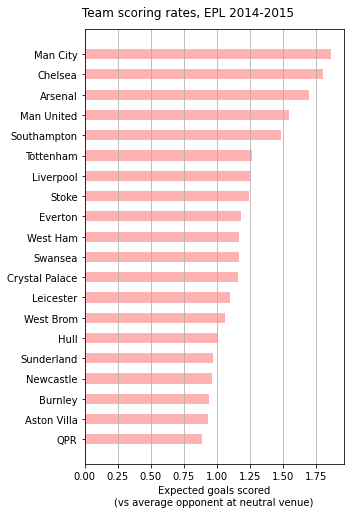

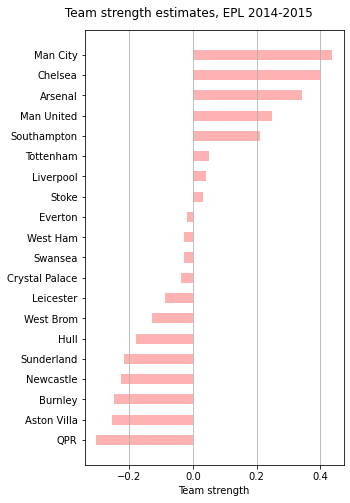

In [20]:
# make plot
team_params = []
for team,lam,theta,sigma in zip(teams,lambdas,thetas,sigma_theta):
    team_params.append((team,lam.round(3),theta.round(3),sigma.round(3)))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)

for params in team_params[::-1]:
    print("%s,%1.3f,%1.3f,%1.3f" % tuple(params))
print("Beta,%1.3f" % (beta))

team_params = sorted(team_params,key=lambda x: x[1], reverse=False)
make_team_strength_plot(season,team_params)

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 26 16:00:35 2020

@author: laurieshaw
"""

import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm

DATADIR = "/Users/sethbilliau/Desktop/stat143/code/data/"

def run_sims(team_param_dict,nsims=10000,draw_strengths=True):    
    # we'll simulated the 2015/16 season using team strengths measured from the 2014/15 season
    season = 2015 # i.e. 2015/16 season

    # load data
    EPLseason = pd.read_csv(DATADIR+'EPL_%d%d.csv' % (season-2000,season-2000+1))

    # get fixture schedule    
    fixtures = EPLseason[['HomeTeam','AwayTeam']]
    teams = np.unique( fixtures[['HomeTeam','AwayTeam']] )
    
    # calculate the average of team strength of teams that were relegated in the 2014/15 season
    relegated_teams_theta = (team_param_dict['Hull']+team_param_dict['Burnley']+team_param_dict['QPR'])/3.
    # assign this average strength to the newly promoted teams (beacuse they werent in the league in 2014/15)
    promoted_teams = ['Bournemouth','Watford','Norwich']
    for promoted_team in promoted_teams:
        team_param_dict[promoted_team] = relegated_teams_theta
    
    # store the league tables for each simulation in a list    
    tables = []
    # now run the simulations
    for i in tqdm(np.arange(nsims)):
        if draw_strengths:
            # treat the team strength of each team as a random varaible, drawing from a distribution determined by their expected value and sample error
            sim_param_dict = draw_from_strength_params(teams,team_param_dict)
        else:
            # don't draw team strenghts, just keep them fixed at their expected value
            sim_param_dict = team_param_dict
        # simulate the season once
        completed_fixtures = sim_season(fixtures,sim_param_dict)
        # append the league table for simulated season to the list
        tables.append( generate_table(completed_fixtures) )
        
    team_summary = analyse_sim_results(tables, teams)
    return tables,team_summary


def draw_from_strength_params(teams,team_param_dict,sigma_teams=0.1,sigma_beta=0.3):
    '''
    Draw a new set of team strength, home advantage and intercept parameters from the standard errors on the theta values
    '''
    sim_param_dict = team_param_dict.copy()
    for team in teams:
        sim_param_dict[team] = stats.norm.rvs(0,sigma_teams,1)[0] + team_param_dict[team]
    
    sim_param_dict['intercept'] = stats.norm.rvs(0,sigma_beta,1)[0] + team_param_dict['intercept']
    sim_param_dict['beta'] = stats.norm.rvs(0,sigma_beta,1)[0] + team_param_dict['beta']
    return sim_param_dict

def sim_match(home,away,team_param_dict):
    # calculate lambda (goal scoring rate parameters from team strenghts & home advantage)
    lambda_home = np.exp( team_param_dict[home] - team_param_dict[away] + team_param_dict['intercept'] + team_param_dict['beta'] )
    lambda_away = np.exp( team_param_dict[away] - team_param_dict[home] + team_param_dict['intercept'] - team_param_dict['beta'] )
    # draw a poisson random variable
    hg = stats.poisson.rvs(lambda_home)
    ag = stats.poisson.rvs(lambda_away)
    return hg,ag

def sim_season(fixtures,team_param_dict):
    '''
    simulate a single season using the fixtures given in the 'fixtures' dataframe
    '''
    # make a copy of the fixture list. we'll populate this with the results
    completed_fixtures = fixtures.copy()
    nmatches = fixtures.shape[0]
    HomeGoals = np.zeros(nmatches,dtype=int)
    AwayGoals = np.zeros(nmatches,dtype=int)
    # go through fixture schedule and simulated each match
    for i,row in completed_fixtures.iterrows():
        HomeGoals[i],AwayGoals[i] =sim_match(row['HomeTeam'],row['AwayTeam'],team_param_dict)
    # fill in scores in fixture schedule
    completed_fixtures['HomeGoals'] = HomeGoals
    completed_fixtures['AwayGoals'] = AwayGoals
    return completed_fixtures
    
def generate_table(results):
    ''' 
    produce a league table from a simulation of a single team
    '''
    teams = np.unique( results[['HomeTeam','AwayTeam']] )
    table = []
    # loop through each team
    for team in teams:
        # get all the team's home & away games
        homegames = results[results['HomeTeam']==team]
        awaygames = results[results['AwayTeam']==team]
        # calculate total number of goals scored
        GoalsFor = np.sum(homegames.HomeGoals) + np.sum(awaygames.AwayGoals)
        # calculate total number of goals conceded
        GoalsAgainst = np.sum(awaygames.HomeGoals) + np.sum(homegames.AwayGoals)
        # calculate total number of points won in home games
        HomePoints = 3*np.sum(homegames.HomeGoals>homegames.AwayGoals) + 1*np.sum(homegames.AwayGoals==homegames.HomeGoals)
        # calculate total number of points won in away games
        AwayPoints = 3*np.sum(awaygames.AwayGoals>awaygames.HomeGoals) + 1*np.sum(awaygames.AwayGoals==awaygames.HomeGoals)
        # add to get total points
        TotalPoints = HomePoints + AwayPoints
        # append results to the table list
        table.append((team,TotalPoints,GoalsFor-GoalsAgainst,GoalsFor,GoalsAgainst))
    # sort the table by points, then goal difference, then goals for
    table = sorted(table, key = lambda x: (x[1],x[2],x[3]), reverse=True)
    return table
    
def analyse_sim_results(tables,teams,printout=True):
    '''
    analyse the simulation results over all simulations
    '''
    team_summary = []
    nsims = len(tables)
    for team in teams:
        # the final of positions of the team in each sim
        positions = np.array( [[t[0] for t in table].index(team)+1 for table in tables] )
        # the final of points of the team in each sim
        points = np.array([table[position-1][1] for table,position in zip(tables,positions)])
        # proportion of sims in which team finished first in the league table
        title = np.sum(positions==1)/nsims*100
        # proportion of sims in which team finished in the top 4 
        top4 = np.sum(positions<=4)/nsims*100
        # proportion of sims in which team finished in the bottom 3 (i.e. were relegated)
        rel = np.sum(positions>=17)/nsims*100
        # average position
        position_mean = np.mean(positions)
        # 2.5th percentile of finishes (by position)
        position_low = np.percentile(positions,2.5)
        # 97.5th percentile of finishes
        position_high = np.percentile(positions,97.5)
        # average points
        points_mean = np.mean(points)
        # 2.5th and 97.5th percentiles of points
        points_low = np.percentile(points,2.5)
        points_high = np.percentile(points,97.5)
        # add to summary table
        team_summary.append( [position_mean,team,points_mean,points_low,points_high,position_low,position_high,title,top4,rel] )
    # sort summary table by mean position
    team_summary = sorted( team_summary, key = lambda x: x[0], reverse=False)
    if printout:
        print("\n******* SUMMARY OF SIMULATION RESULTS **********\n")
        print("Position, Team,Points-Mean,Points-Low,Points-High,Position-Low,Position-High,Title,Top4,Relegation")
        for i,summary in enumerate(team_summary):
            print("%d,%s,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f,%1.1f" % tuple([i+1]+summary[1:]))
    return team_summary



In [ ]:
tables, team_summary = run_sims(team_param_dict)

  4%|▎         | 356/10000 [00:47<23:37,  6.81it/s]